In [144]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spl

### Nonlinear differential Equation

We want to solve the nonlinear differential equation

$$ -u^{''} = \sin(u) + f(x)\qquad u(0) = u(1) = 0  . $$


The true solution $u_*(x) = x(1-x)$ and the function $f(x) = 2 - \sin(x(1-x)).$


#### Discretizing this problem

As in the homework, we discretize the problem using finite differences. We divide the domain $[0,1]$ into $N+2$ points $x_i = i/(N+1)$, with $u_0 = u_{N+1} = 0$. We can discretize the second derivative as 
$$u_j^{''} \approx \frac{u_{j+1} - 2u_j + u_{j-1}}{h^2}  \qquad j = 1,\dots,N.$$

This gives the nonlinear equation

$$ F(u) = Au - \sin(u) - b,  $$

where $\sin(\cdot)$ is applied componentwise to the vector

$$ A = \frac{1}{h^2}\begin{bmatrix}2 & -1 \\ -1 & 2 & \ddots \\  & \ddots & \ddots & -1 \\ & & -1  & 2 \end{bmatrix} \qquad b_i =  2 - \sin(x_i(1-x_i)). $$


The jacobian can be computed analytically and takes the form

$$ J(u) = F'(u) = A - \text{diag}(\cos(u_1), \dots, \cos(u_N)). $$ 


### Implement Newton's method

We use a direct solver for computing the new step.

In [145]:
from scipy.sparse.linalg import spsolve

def newton(F,J,x0, maxiter = 100, atol = 1.e-10, rtol = 1.e-10):
    """
    Newton's method for solving F(x) = 0
    
    """
    
    Fx0 = F(x0)
    
    reshist = []
    
    iterc = 0
    xkm1 = np.copy(x0)
    while True:
        iterc += 1
        
        Fkm1 = F(xkm1)
        Jkm1 = J(xkm1)
        
        resk = np.linalg.norm(Fkm1)/np.linalg.norm(Fx0)
        reshist.append(resk)
        print('The relative residual at step %d is %g' % (iterc, resk))
    
        #Factorize and solve
        pk  = spsolve(Jkm1, -Fkm1)
        
        #Update the solution
        xk = xkm1 + pk
        
        if (np.linalg.norm(F(xk)) <= atol + rtol*np.linalg.norm(Fx0)) or (iterc > maxiter): 
            break
        
        #Update for the next iteration
        xkm1 = xk
        
        
    return xk, iterc, reshist 
    

#### Solve Newton's equations and plot the solution

In [146]:
N = 500
h = 1/(N+1)

x = np.arange(N+2)*h


## Define the tridiagonal matrix b and the vector b
e = np.ones((N,))
data = [-e[:-1], 2*e, -e[:-1]]
A = (1/h**2.)*sp.diags(data, np.array([-1,0,1]), shape = (N,N))
b = 2 - np.sin(x[1:-1]*(1-x[1:-1]))



## Define the nonlinear function and the jacobian 
F = lambda u: A @ u - np.sin(u) - b
J = lambda u: A - sp.diags([np.cos(u)], [0], shape = (N,N))

The relative residual at step 1 is 1
The relative residual at step 2 is 0.000829276
The relative residual at step 3 is 2.13689e-09


Text(0.5, 1.0, 'Relative Residual History')

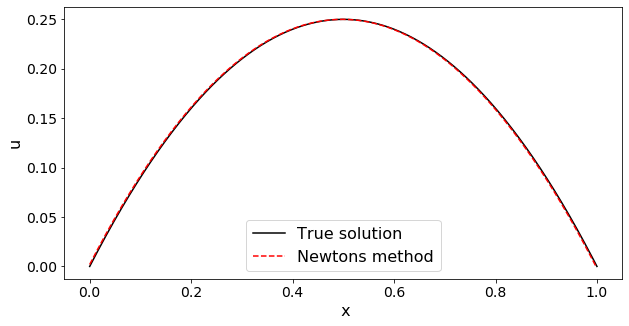

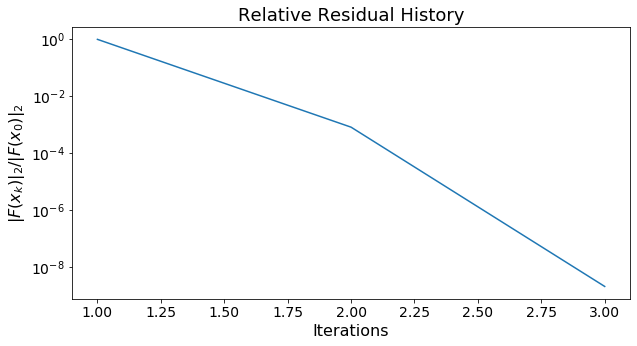

In [147]:
u0 = np.zeros((N,))
us, iterc, reshist = newton(F,J,u0, maxiter = 10)

#Compute and plot against exact solution
uex = x*(1-x)
up = np.zeros((N+2))
up[:-2] = us
plt.plot(x, uex, 'k-', x, up, 'r--')
plt.xlabel(' x', fontsize = 16)
plt.ylabel('u', fontsize = 16)
plt.legend(('True solution','Newtons method'), fontsize = 16)



plt.figure()
plt.semilogy(range(1,len(reshist)+1), reshist)
plt.xlabel('Iterations', fontsize = 16)
plt.ylabel('$\|F(x_k)\|_2/ \|F(x_0)\|_2$', fontsize = 16)
plt.title('Relative Residual History', fontsize = 18)